In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import os

In [3]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [4]:
np.random.seed(42)


In [8]:
DATASET_PATH = r"C:\Users\swath\OneDrive\Desktop\Pneumonia\chest_xray\chest_xray\train"
NORMAL_DIR = os.path.join(DATASET_PATH, "NORMAL")
PNEUMONIA_DIR = os.path.join(DATASET_PATH, "PNEUMONIA")

In [9]:
IMG_SIZE = 128

In [10]:
def load_images(normal_dir, pneumonia_dir, img_size):
    images = []
    labels = []
    
    print("Loading Normal images...")
    for img_name in os.listdir(normal_dir):
        img_path = os.path.join(normal_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
        if img is not None:
            img_resized = cv2.resize(img, (img_size, img_size))  
            images.append(img_resized)
            labels.append(0)  # 0 for Normal

    print("Loading Pneumonia images...")
    for img_name in os.listdir(pneumonia_dir):
        img_path = os.path.join(pneumonia_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (img_size, img_size))
            images.append(img_resized)
            labels.append(1)  # 1 for Pneumonia
    
    return np.array(images), np.array(labels)

# Load the dataset
X, y = load_images(NORMAL_DIR, PNEUMONIA_DIR, IMG_SIZE)

print(f"Total images loaded: {len(X)}")
print(f"Image shape: {X[0].shape}")
print(f"Normal cases: {np.sum(y == 0)}")
print(f"Pneumonia cases: {np.sum(y == 1)}")

Loading Normal images...
Loading Pneumonia images...
Total images loaded: 5216
Image shape: (128, 128)
Normal cases: 1341
Pneumonia cases: 3875


In [11]:
X_normalized = X/255.0
X_flattened = X_normalized.reshape(len(X), -1)
print(f"Original shape: {X_normalized.shape}")
print(f"Flattened shape: {X_flattened.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    X_flattened, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Original shape: (5216, 128, 128)
Flattened shape: (5216, 16384)

Training samples: 4172
Test samples: 1044


In [12]:
print("Training KNN model...")
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
print("KNN model trained!")

Training KNN model...
KNN model trained!


Accuracy: 93.68%

              precision    recall  f1-score   support

      Normal       0.93      0.81      0.87       268
   Pneumonia       0.94      0.98      0.96       776

    accuracy                           0.94      1044
   macro avg       0.93      0.90      0.91      1044
weighted avg       0.94      0.94      0.94      1044



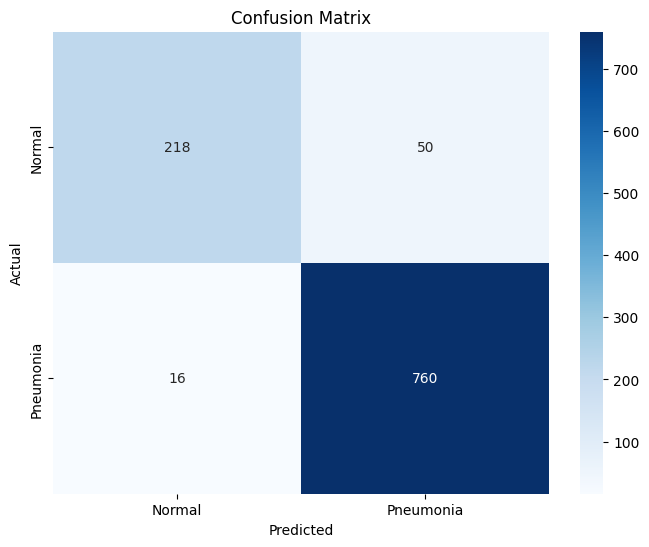

In [14]:
y_pred = knn.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")

# metrics
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import joblib

# Save model + config
model_bundle = {
    "model": knn,
    "img_size": IMG_SIZE
}

joblib.dump(model_bundle, "knn_pneumonia_model.pkl")

print("Model saved successfully!")


Model saved successfully!


In [20]:
import joblib
data = joblib.load("knn_pneumonia_model.pkl")
knn = data["model"]
IMG_SIZE = data["img_size"]

print("Model loaded successfully")

Model loaded successfully


In [56]:
import cv2
import numpy as np

def preprocess_image(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or unreadable")

    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = img.reshape(1, -1)
    return img

In [58]:
img_path = "img_size.jpeg"  # any new chest X-ray image

img = preprocess_image(img_path, IMG_SIZE)
prediction = knn.predict(img)

if prediction[0] == 1:
    print("Prediction: Pneumonia")
else:
    print("Prediction: Normal")

Prediction: Pneumonia


In [59]:
# Test Dataset
TEST_PATH = r"C:\Users\swath\OneDrive\Desktop\Pneumonia\chest_xray\chest_xray\test"
TEST_NORMAL_DIR = os.path.join(TEST_PATH, "NORMAL")
TEST_PNEUMONIA_DIR = os.path.join(TEST_PATH, "PNEUMONIA")

X_test_full, y_test_full = load_images(TEST_NORMAL_DIR, TEST_PNEUMONIA_DIR, IMG_SIZE)

# Preprocess
X_test_normalized = X_test_full / 255.0
X_test_flattened = X_test_normalized.reshape(len(X_test_full), -1)

# Predict
y_test_pred = knn.predict(X_test_flattened)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_full, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Show detailed metrics
print("\nTest Set Classification Report:")
print(classification_report(y_test_full, y_test_pred, target_names=['Normal', 'Pneumonia']))

Loading Normal images...
Loading Pneumonia images...
Test Accuracy: 73.24%

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.29      0.45       234
   Pneumonia       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.64       624
weighted avg       0.80      0.73      0.68       624

